In [2]:
import warnings # We'll use this to suppress warnings caused by TensorFlow
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # generating plot

import tensorflow as tf # modeling/training

import time # Used for epoch timing

import imageio # GIF generation
import glob # GIF generation
import PIL # GIF generation


import os
data_dir = '../celebrity_images_dataset'
os.listdir(data_dir)

['img_align_celeba',
 'list_attr_celeba.csv',
 'list_bbox_celeba.csv',
 'list_eval_partition.csv',
 'list_landmarks_align_celeba.csv']

In [3]:
list_eval_partition = pd.read_csv(f'{data_dir}/list_eval_partition.csv')
names_df = list_eval_partition['image_id']
names_df.head()

0    000001.jpg
1    000002.jpg
2    000003.jpg
3    000004.jpg
4    000005.jpg
Name: image_id, dtype: object

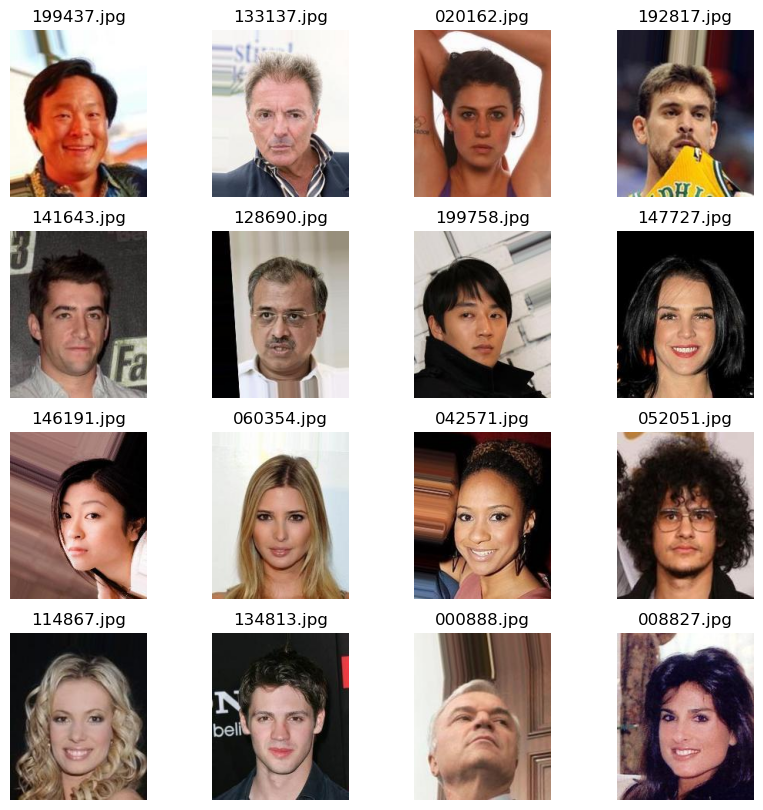

In [4]:
img_names = names_df.sample(n=16).values
shapes = []
plt.figure(figsize=(10,10))
for i, name in enumerate(img_names):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(data_dir +'/img_align_celeba/' + name)
    shapes.append(img.shape)
    plt.imshow(img)
    plt.title(name)
    plt.axis('off')
_=plt.suptitle('')

We will use this function to load the image, resize it to the size necessary for our models, and then preprocess it (currently only centering and rescaling). Im resizing based on what I need for the models - it'll become more clear why we are resizing when you see the models

In [5]:
def load_and_preprocess_image(name):
    image = tf.io.read_file(data_dir +'/img_align_celeba/' + name)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, (216, 176))
    image = (image - 127.5) / 127.5
    return image

In [6]:
BATCH_SIZE = 256

In [7]:
name_ds = tf.data.Dataset.from_tensor_slices(names_df.values)
image_ds = name_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
image_ds = image_ds.shuffle(buffer_size=2000).batch(BATCH_SIZE)

num_batches = int(np.ceil(len(names_df) / BATCH_SIZE))
print('There are {} batches'.format(num_batches))

There are 792 batches


In [8]:
from tensorflow.keras import layers
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(12*11*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((12, 11, 128)))
    assert model.output_shape == (None, 12, 11, 128)

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(3, 4), padding='same', use_bias=False))
    assert model.output_shape == (None, 36, 44, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(3, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 108, 88, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 216, 176, 3)

    return model

C:\Users\TEJKIRAN\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16896)               │       1,689,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16896)               │          67,584 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16896)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 12, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 36, 44, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 36, 44, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 36, 44, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 108, 88, 32)         │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 108, 88, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 108, 88, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 216, 176, 3)         │           2,400 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,015,968 (7.69 MB)

 Trainable params: 1,981,984 (7.56 MB)

 Non-trainable params: 33,984 (132.75 KB)

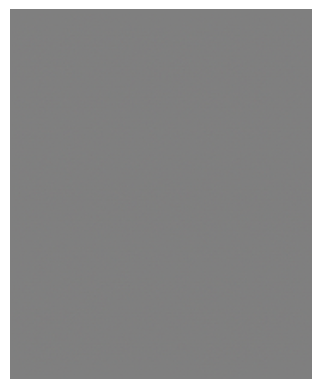

In [9]:
generator = make_generator_model()
noise_image = tf.random.normal([1,100,])
generated_image = generator(noise_image, training=False)
plt.imshow((generated_image[0]*127.5 +127.5) / 255.)
_=plt.axis('off')
generator.summary()

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[216, 176, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = make_discriminator_model()
discriminator.summary()
print(discriminator(generated_image))

C:\Users\TEJKIRAN\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 108, 88, 64)         │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 108, 88, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 108, 88, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 54, 44, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 54, 44, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 44, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 304128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │         304,129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 513,921 (1.96 MB)

 Trainable params: 513,921 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

tf.Tensor([[-0.00128306]], shape=(1, 1), dtype=float32)


### Loss Function

In [12]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_obj(tf.ones_like(real_output), real_output)
    fake_loss = loss_obj(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return loss_obj(tf.ones_like(fake_output), fake_output)

### Optimizer

In [12]:
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save Checkpoints

In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer,
                                 discriminator_optimizer=disc_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [14]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)
        
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    
    return gen_loss, disc_loss

In [15]:
import os

folder_path = 'celebrity_output_images'
if not os.path.exists(folder_path):
    os.makedirs(folder_path,exist_ok=True)

In [16]:
def show_and_generate_images(model, epoch, test_output):
    predictions = model(test_output, training=False)
    
    plt.figure(figsize=(10,10))
    for i in range(len(test_output)):
        plt.subplot(4,4,i+1)
        plt.imshow((predictions[i] * 127.5 +127.5) / 255.)
        plt.axis('off')
        
    plt.savefig('{}/image_at_epoch_{:04d}.png'.format(folder_path,int(epoch)))
    _=plt.show()

In [17]:
def train(dataset, epochs):
    print('Begining to train...')
    
    history = pd.DataFrame(['gen_loss', 'disc_loss'])
    for epoch in range(epochs):
        start = time.time()
        epoch_gen_loss = tf.keras.metrics.Mean()
        epoch_disc_loss = tf.keras.metrics.Mean()
        for i, images in enumerate(dataset):
            gen_loss, disc_loss = train_step(images)
            epoch_gen_loss.update_state(gen_loss)
            epoch_disc_loss.update_state(disc_loss)
            
        random_noise = tf.random.normal([16, 100])

        show_and_generate_images(generator, epoch + 1, random_noise)
        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        stats = 'Epoch {0} took {1} seconds. Gen_loss: {2:0.3f}, Disc_loss: {3:0.3f}'
        print(stats.format(epoch + 1, int(time.time() - start), 
                           epoch_gen_loss.result().numpy(), 
                           epoch_disc_loss.result().numpy()))
        history = history.append({'gen_loss': epoch_gen_loss.result().numpy(), 
                                  'disc_loss': epoch_disc_loss.result().numpy()}, 
                                  ignore_index=True)
        
    return history

In [ ]:
EPOCHS = 100
history = train(image_ds, EPOCHS)
history.index = history.index + 1

In [19]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

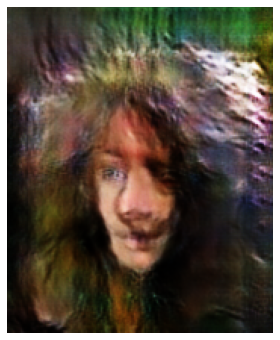

In [21]:
import matplotlib.pyplot as plt
import tensorflow as tf

noise = tf.random.normal([1, 100])  # Generate noise for a single image
generated_image = generator(noise, training=False)[0]  # Get the generated image

# Plot and save the generated image
def plot_single_image(image, filename):
    plt.figure(figsize=(6, 6))
    plt.imshow((image * 127.5 + 127.5) / 255.)
    plt.axis('off')
    plt.savefig(filename)
    plt.show()

# Specify the filename to save the generated image
output_filename = 'single_generated_image.png'

# Display the generated image
plot_single_image(generated_image, output_filename)